# Modelando la Pandemia

  En este proyecto vamos a estudiar y analizar los datos mundiales de la pandemia COVID-19 usando países modelo de distintas políticas públicas para luego interpretar otras curvas.

Puedes descargar el dataset de casos totales, divididos por país [aquí.](
https://ourworldindata.org/coronavirus-data?country=
) Descarga los datos  formato .csv luego podrás cargarlos en el notebook usando pandas, a partir de eso selecciona los de los países que te interesan, hay un ejemplo de cómo se hace esto en este notebook. 

# ¿Cómo empezó la pandemia?


  La primer parte del trabajo consiste en estudiar cómo se empieza a propagar la pandemia, luego analizaremos las medidas tomadas y su efectividad.

  Al inicio de una pandemia, se estima que los contagios siguen una ley exponencial, esa es la fase de "crecimiento exponencial", luego hay un decaimiento dado por la inmunidad. 

  Los datos de casos confirmados en función del tiempo $C(t)$, pueden aproximarse con el modelo

$C(t)=e^{k(t-t_0)}$

donde $t_0$ es la fecha del primer contagio, y $k$ es un parámetro propio de cada enfermedad, que habla de la contagiosidad. Cuanto mayor es $k$, más grande será el número de casos confirmados dado por la expresión. $k$ depende de el tiempo que una persona enferma contagia, el nivel de infecciosidad del virus y cuántas personas que se pueden contagiar ve una persona enferma por día. Es decir, la circulación. Haciendo cuarententa, $k$ disminuye, con la circulación $k$ aumenta.

  El parámetro $k$ está directamente relacionado con el $R$ del que tanto se habla en los medios. En este proyecto haremos foco en $k$, pero puedes profundizar sobre esto si quieres, empezandó por [aquí](https://es.wikipedia.org/wiki/Ritmo_reproductivo_b%C3%A1sico). 

  Es posible hacer un modelo completo, pero para eso es necesario utilizar ecuaciones diferenciales. Si quieres profundizar sobre eso, busca información sobre "modelo epidemiológico SEIR". Si quieres ver cómo funciona este modelo, puedes empezar por [aquí](http://gabgoh.github.io/COVID/index.html). En ese link está implementado el modelo SEIR (no es necesario entender las ecuaciones en este caso) y el rol que cumplen los parámetros, puedes explorar el impacto de variar $R$ y el resto de los valores para ver cómo impactan en la cirva de contagios. Ahora utilizaremos la siguiente expresión para describir únicamente la etapa de crecimiento exponencial.


  Comienza estudiando cómo se distribuyó el $k$ inicial de la pandemia y si es posible elaborar un intervalo de confianza razonable para este valor. Para eso 
  
  1. Elegir diez países del norte (ahí empezó la pandemia) y puedes mide el valor de $k$ inicial de la pandemia, analizando datos del primer tramo.

  2. Analiza si es posible estimar la evolución mundial de la pandemia a partir de lo que obtuviste. Para esto, puedes elaborar un intervalo de confianza para $k$ a partir de los que obtuviste y así generar un modelo nuevo, basado en la distribución de $k$. Luego compara el modelo con los datos mundiales.

3. Piensa qué significa que el modelo de "bien" o dé "mal" ¿qué indicadores de esto existen?. Luego discute en el informe por qué crees que dio así. Recuerda que es importante elegir bien la población de muestra. Piensa qué criterios puedes elegir para representar bien la población mundial que se contagió al inicio de la pandemia.
 
 # Evaluando estrategias

 Ahora que tienes una manera de obtener información de las curvas, puedes intentar evaluar las estrategias de acción y el comportamiento de las poblaciones, construyendo un clasificador binario. 
1. Elige una categoría binaria que hable de políticas públicas elegidas por los países para enfrentar la pandemia que te interese estudiar, como pueden ser "la población hizo cuarententa" o "la población se vacunó".
2. Piensa qué indicadores de la curva pueden hablar del éxito de la política que quieres estudiar. Por ejemplo, si se tratase de evaluar el éxito de una cuarentena podría ser porcentaje de población  que se contagió o variación del valor de $k$ a partir de que se empezó a implementar esa medida. Elige al menos 3 indicadores.
3. Investiga sobre países que hayan aplicado o no esa política pública, para generar una base de datos. Por ejemplo, Brasil no hizo cuarentena y China hizo una muy estricta. Recuerda hacer una selección inteligente de la porción de datos de la curva de cada país que vas a analizar.
4. Construye un clasificador binario a partir de una regresión logística o usando Naive Bayes para intentar analizar la estrategia de otros países y ver si es posible predecirla a partir de la curva de contagios y el clasificador. Un posible clasificador binario es uno que clasifique el porcentaje de contagios en función da las categorías "la población hizo cuarentena" y "la población n hizo cuarentena". Haz esto para los 3 indicadores que elegiste en el punto 3 y compara los resultados.
5. Elabora un informe con lo que hayas aprendido a lo largo de este proyecto, donde discutas la utilidad o no de los indicadores que elegiste y del análisis estadístico propuesto.

# ¡Comencemos!

  A continuación dejamos un ejemplo de cómo extraer el $k$ inicial de Argentina, usando un ajuste de cuadrados mínimos. Si necesitas los datos mundiales, en la columna de países aparecen como "World".



In [2]:
import numpy as np
import pandas as pd
import pylab as plt
from scipy import stats
#from google.colab import drive
from scipy.optimize import curve_fit
#conda install -c plotly plotly
#import plotly.express as px
import seaborn as sns
# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')
import itertools
# Varios
# ==============================================================================
from tqdm import tqdm
#from tqdm import tqdm_notebook as tqdm
from sklearn import metrics

Cargamos el data set y realizamos un analisis exploratorio eligiendo a Argentina como País.

In [3]:
#datos=pd.read_csv('/content/gdrive/My Drive/datos_acamica/datos_covid.csv')
datos=pd.read_csv('data/owid-covid-data.csv')
datos_orig = datos.copy()

In [4]:
datos2 = datos[['location','iso_code','date','total_tests','total_deaths','total_cases','population']]

In [5]:
#datos.info()

In [6]:
paises=datos2['location'] #cargo el vector de paises
confirmados=datos2['total_cases'] #carga vector todos los casos confirmados
population=datos2['population'] #carga vector todos los casos confirmados

Text(0, 0.5, 'cantidad de casos')

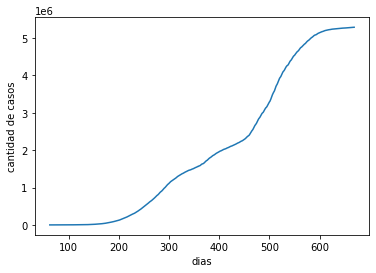

In [7]:
#seleccionamos Argentina
ind_arg=np.where(paises=='Argentina')
ind_arg=ind_arg[0]
casos_arg=confirmados[ind_arg]
dias=np.arange(0,len(casos_arg))
plt.plot(dias,casos_arg)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Observamos que en Argentina el primer caso de Covid no fue inmediatamente posterior al primer caso detectado en el mundo. Para determinar el día en que se detectó el primer caso en Arg primero vamos a filtrar por Pais, allí obtenemos los indices.

In [8]:
#paises[paises == 'Argentina']
#ind_arg[0]
ind_arg[:10]
# o podemos hacer esto
#np.where(paises=='Argentina')

array([4525, 4526, 4527, 4528, 4529, 4530, 4531, 4532, 4533, 4534])

In [9]:
#confirmados[ind_arg]

In [10]:
#Transformamos el array a lista
lst = list(casos_arg)

In [11]:
# Buscamos el primer valor no nulo, sería el primer día con casos
#casos_arg[np.isfinite(casos_arg)][0]
lst[lst.index(next(filter(lambda x: not np.isnan(x), lst)))]

1.0

In [12]:
# Buscamos el indice del primer elemento no nulo
lst.index(next(filter(lambda x: not np.isnan(x), lst)))

62

In [13]:
## entonces el primer caso corresponde al indice 4391
casos_arg[62:][:5]

4587    1.0
4588    1.0
4589    1.0
4590    2.0
4591    8.0
Name: total_cases, dtype: float64

Una vez obtenido el primer elemento no nulo, es decir cuando ocurre el primer caso, podemos saber cual es la fecha a partir de indice obtenido.

In [14]:
# primer caso de covid en Argentina
datos2.loc[4391]

location        Antigua and Barbuda
iso_code                        ATG
date                     2021-06-20
total_tests                     NaN
total_deaths                   42.0
total_cases                  1263.0
population                  98728.0
Name: 4391, dtype: object

Esta es la curva de **casos totales** de la Argentina. Aquí no se ven las olas, ya que estas se ven en la curva de casos confirmados por día, es decir, de casos nuevos. Esta habla de los acumulados, entonces siempre se agregan.

Para ver mejor la curva, podemos tomar el logartimo de los datos. Una curva exponencial se ve lineal en escala logarítmica


Text(0, 0.5, 'log cantidad de casos')

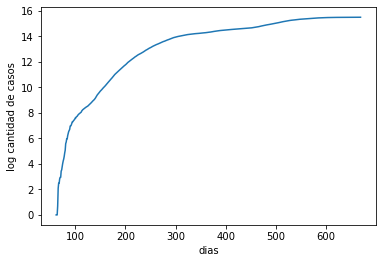

In [15]:
plt.plot(dias,np.log(casos_arg))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

Veamos lo que pasa en los primeros 60 días desde que se detectó el primer caso en Argentina, para ver cómo fue el $k$ inicial

In [16]:
# comenzamos desde el indice 62 que es cuando se detectó el primer caso en Argentina. id 4391
print(list(casos_arg[62:122][:10]))

[1.0, 1.0, 1.0, 2.0, 8.0, 12.0, 12.0, 17.0, 19.0, 19.0]


Text(0, 0.5, 'cantidad de casos')

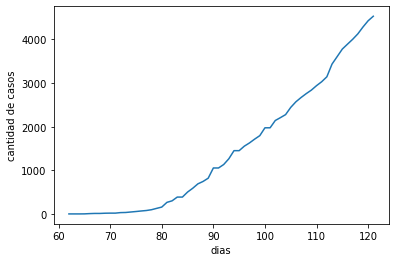

In [17]:
#Se filtra desde el primer día que hubo casos
casos_principio=casos_arg[62:122]
dias_principio=dias[62:122]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Es difícil determinar si esta parte es exponencial. Analicemos qué pasa en escala logarítmica.

Text(0, 0.5, 'log cantidad de casos')

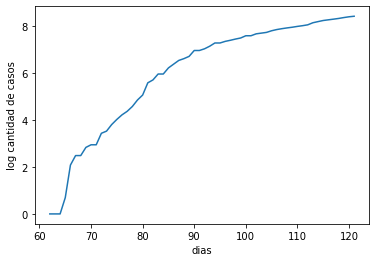

In [18]:
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

Notar que los datos comienzan desde el día 62, que es el día en que se deectó el primer caso de covid en Argentina desde comenzada la pandemia en el mundo. Mejor nos quedamos con lo que sucede entre los días 31 y 55, ya que ese fue el comportamiento más sostenido.

Text(0, 0.5, 'cantidad de casos')

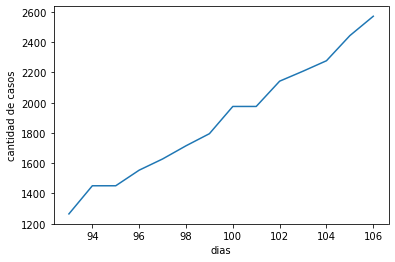

In [19]:
#casos_principio=casos_arg[31:55]
#dias_principio=dias[31:55]

casos_principio=casos_arg[93:107]
dias_principio=dias[93:107]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Text(0, 0.5, 'log cantidad de casos')

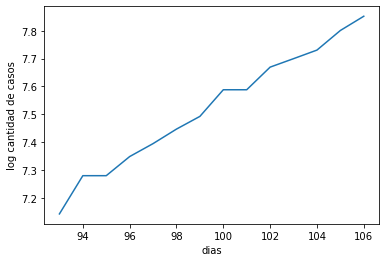

In [20]:
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

¡Se ve bastante lineal! Aprovechemos esto para averiguar el $k$ utilizando un ajuste hecho con el método de cuadrados mínimos, ajustando los datos al modelo 

$Confirmados=e^{k(t-t_0)}$



In [21]:
#definimos función para ajustar modelo
def exponencial(t,k,t0):
  C=np.exp(k*(t-t0))
  return C

In [22]:
#ajustamos, popt[0] es nuestro "K" y popt[1] t0
popt, pcov = curve_fit(exponencial, dias_principio, casos_principio)
popt

array([  0.05065185, -49.02984924])

**popt :** Valores optimos para los parámetros, donde la suma del error cuadratico es minimizado. El primer elemento para nuestra función definida es el valor `k` y el segundo es `t0`

**pcov :** La covarianza estimada de popt. La diagonal provee la varianza del parametro estimado. Para computar el error, la desviación estandar de un parámetro hay usar perr = np.sqrt(np.diag(pcov)).

In [23]:
popt

array([  0.05065185, -49.02984924])

In [24]:
pcov

array([[1.94919125e-06, 5.77705715e-03],
       [5.77705715e-03, 1.71333636e+01]])

In [25]:
perr = np.sqrt(np.diag(pcov))
#float(perr)p
perr

array([1.39613439e-03, 4.13924674e+00])

In [26]:
#print("El intervalo de confianza para K es: {} - {}".format( round(perr[0],3), round(perr[1],3) ))

Veamos cómo se ajusta lo que obtuvimos a los datos reales

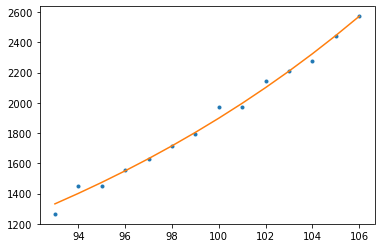

In [27]:
k=popt[0]
t0=popt[1]
casos_simu=exponencial(dias_principio,k,t0)
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)

In [28]:
print(list(dias_principio))

[93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106]


In [29]:
print(list(casos_principio))

[1265.0, 1451.0, 1451.0, 1554.0, 1628.0, 1715.0, 1795.0, 1975.0, 1975.0, 2142.0, 2208.0, 2277.0, 2443.0, 2571.0]


Como última pista, hagamos una función que determine los casos nuevos por día a partir de estas curvas. Puede ser útil para tu análisis.

In [30]:
def casos_nuevos(casos):
  nuevos=np.zeros(len(casos))
  i=0
  while i<len(nuevos)-1:
    nuevos[i]=casos[i+1]-casos[i]
    i=i+1

  return nuevos   

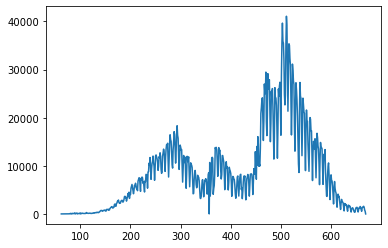

In [31]:
casos_arg=np.array(casos_arg)
nuevos_arg=casos_nuevos(casos_arg)
plt.plot(nuevos_arg)

Analiza si es posible estimar la evolución mundial de la pandemia a partir de lo que obtuviste. Para esto, puedes elaborar un intervalo de confianza para  𝑘  a partir de los que obtuviste y así generar un modelo nuevo, basado en la distribución de  𝑘 . Luego compara el modelo con los datos mundiales.

#### 1) Elegir diez países del norte (ahí empezó la pandemia) y puedes mide el valor de  𝑘  inicial de la pandemia, analizando datos del primer tramo.

Datos: Locations paises- Creamos una función que muestre cuando fue la aparición del primer caso y la evolución

In [32]:
#datos[datos.location == list_paises]
#datos[datos["location"].isin([list_paises])]
print(list(paises.unique()[0:10]))

['Afghanistan', 'Africa', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia']


100%|██████████| 12/12 [00:00<00:00, 47.79it/s]


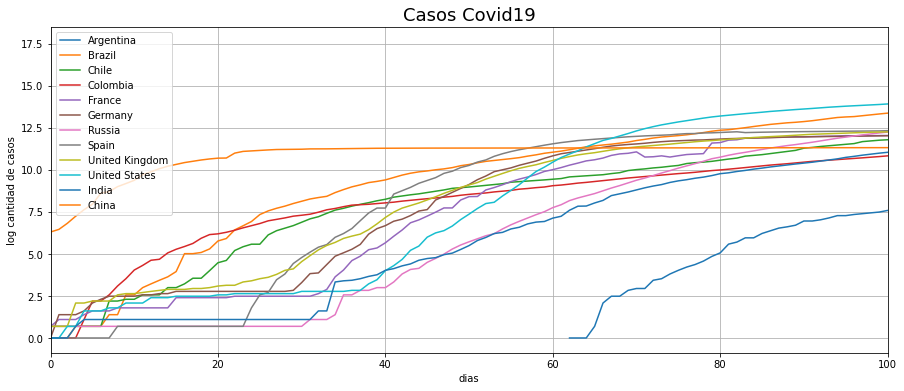

In [33]:
## Inicio de analisis

lista_paises = ['Argentina','Brazil','Chile','Colombia','France','Germany','Russia','Spain','United Kingdom','United States','India','China']
#lista_paises = ['Argentina','Brazil','Chile','Colombia']

#armamos la figura para el gráfico
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Casos Covid19',fontsize=18, loc='center')
ax.set_xlim([0, 100])
ax.grid()

for x_pais in tqdm(lista_paises):
    #seleccionamos Argentina
    ind_xpais=np.where(paises==x_pais)
    ind_xpais=ind_xpais[0]
    
    casos_xpais=confirmados[ind_xpais]
    #Transformamos a lista
    lst = list(casos_xpais)
    # Buscamos el primer valor no nulo, sería el primer día con casos
    ##from numpy import nan
    #casos_arg[np.isfinite(casos_arg)][0]
    primer_caso=lst[lst.index(next(filter(lambda x: not np.isnan(x), lst)))]
    # Buscamos el indice del primer elemento no nulo
    ind_x = lst.index(next(filter(lambda x: not np.isnan(x), lst)))
    # primer caso de covid en Argentina
    dia_start = datos2.date.loc[ind_x]
    #print("En {} el/los primer/primeros {} casos fue el día {} indice {}".format(x_pais,primer_caso, dia_start, ind_x))
    
    ## Graficamos
    #fig, ax = plt.subplots(figsize=(8,3))
    dias=np.arange(0,len(casos_xpais))
    #ax.set_xticklabels(models, rotation=0)    
    fig = plt.plot(dias,np.log(casos_xpais),label=x_pais)
    plt.xlabel('dias')
    plt.ylabel('log cantidad de casos')
    #ax.set_xticklabels(models, rotation=0)
    ax.legend()

Se observa el crecimiento exponencial, en el caso de Argentina el primer caso fue 62 días posteriores al detectado el primer caso en el mundo. Para todos los paises se tomará 35 días después de detectado el primer caso, desde allí se puede observar un crecimiento continuo.

La siguiente función calculará el `K` y `t0` para cada pais de una lista elegida (10 paises del emisferio norte donde comenzó la pandemia)

In [276]:
#lista vacia para guardar los mejores valores de k obtenidos para cada modelo según el país.
lista_k = []
lista_t0 = []
lista_casos_max = []
lista_population = []

#definimos función para ajustar modelo
def exponencial(t,k,t0):
    C=np.exp(k*(t-t0))
    return C

#definimos función para calcular k para cada pais 
def calcular_k(lista_paises):
    '''
    Función para calcular el valor de k.
    
    Parameters
    ----------
    lista_paises : lista con los nombres de los 
        paises a evaluar.
         
    Returns
    -------
    valor k: lista
        con valor de k.
    '''
    
    #armamos la figura para el gráfico
    #fig, ax = plt.subplots(figsize=(15,6))
    fig, axes = plt.subplots(2, figsize=(15, 12))
    fig.suptitle('Casos Covid19', fontsize=20)
    fig.tight_layout(pad=4.0)

    axes[0].set_title('Casos Covid19 Logaritmico',fontsize=14, loc='center')
    axes[0].set_xlim([0, 85])
    axes[0].grid()

    axes[1].set_title('Casos Covid19 Simulados',fontsize=14, loc='center')
    axes[1].set_xlim([0, 85])
    #axes[1].set_ylim([0, 200000])
    axes[1].grid()

    #color lineas gráfico
    marker = itertools.cycle(('o', 'v', '^', '<', '>', 's', '8', 'p'))


    for x_pais in lista_paises:
        #seleccionamos Pais
        ind_xpais=np.where(paises==x_pais)
        ind_xpais=ind_xpais[0]
        ##poblacion x pais
        poblacion_xpais=int(population[0])
       
        #casos
        casos_xpais=confirmados[ind_xpais]
        dias=np.arange(0,len(casos_xpais))
        #Imputamos los nan con 0
        #casos_xpais.fillna(0, inplace=True)
    
        
        #Transformamos a lista
        lst = list(casos_xpais)
        # Buscamos el primer valor no nulo, sería el primer día con casos
        ##from numpy import nan
        #casos_arg[np.isfinite(casos_arg)][0]
        primer_caso=lst[lst.index(next(filter(lambda x: not np.isnan(x), lst)))]
        # Buscamos el indice del primer elemento no nulo
        ind_x = lst.index(next(filter(lambda x: not np.isnan(x), lst)))
        # primer caso de covid en Argentina
        dia_start = datos2.date.loc[ind_x]
        print("En {} el/los primer/primeros {} casos fue el día {} indice {}".format(x_pais,primer_caso, dia_start, ind_x))
    
        ## Graficamos
        
        #color de la lineas
        color = next(ax._get_lines.prop_cycler)['color']
        
        #fig, ax = plt.subplots(figsize=(8,3))
        dias=np.arange(0,len(casos_xpais))
        #ax.set_xticklabels(models, rotation=0)    
        axes[0].plot(dias,np.log(casos_xpais),label=x_pais, color=color)
        axes[0].set_xlabel('dias')
        axes[0].set_ylabel('log cantidad de casos')
        #ax.set_xticklabels(models, rotation=0)
        axes[0].legend()
    
        ################# Estimamos K
        
        dia_desfase = 0
        ind_inicio = ind_x + dia_desfase
        ind_final = ind_inicio + dia_desfase + 60
        
        #dias=np.arange(0,len(casos_arg))
    
        print("{} ind_inicio {}  ind_final {}".format(x_pais,ind_inicio,ind_final))
        casos_principio=casos_xpais[ind_inicio:ind_final]
        dias_principio=dias[ind_inicio:ind_final]
        print(list(dias_principio))    
        print(list(casos_principio))

        #ajustamos, popt[0] es nuestro "K" y popt[1] t0
        popt, pcov = curve_fit(exponencial, dias_principio, casos_principio)
        #popt
    
        #Guardamos el valor de k y t0 en la lista:
        lista_k.append(popt[0])
        lista_t0.append(popt[1])
        lista_casos_max.append(casos_principio.max())
        lista_population.append(poblacion_xpais)
        
        # Ajustamos los datos con los valores de los parámetros obtenidos
        k=popt[0]
        t0=popt[1]
        print("PARAMETRO K: ",k)    
        print("PARAMETRO t0: ",t0)
        print(dias_principio.size)
        print(casos_principio.size)
        print(casos_principio.min())
        print(casos_principio.max())

        casos_simu=exponencial(dias_principio,k,t0)
        ## Graficamos las simulaciones

        axes[1].plot(dias_principio,casos_principio,'.', color=color)
        axes[1].plot(dias_principio,casos_simu,label=x_pais, color = color)
        axes[1].set_xlabel('dias')
        axes[1].set_ylabel('cantidad de casos')
        axes[1].legend()
        
    return lista_k, lista_casos_max, lista_population

Definimos la lista de paises para entrenar nuestro modelo y obtener los mejores parámetros de `K` y `t0`

In [277]:
# lista de paises a evaluar, elegimos inicialmente 10 paices del emisferio Norte
#lista_paises = ['Denmark','Italy','Israel','Portugal','France','Germany','Russia','Spain','United Kingdom','United States','India','China']
lista_paises = ['Denmark','Italy','Israel','Portugal','France','Germany','Russia','Spain','United Kingdom','Belgium','India','Sweden']

#lista_paises = ['Argentina','Brazil','Chile','Colombia']
#lista_paises = ['France','Germany','Italy']

Ejecutamos la función pasandole como argumento la lista de paises anteriormente definida:

In [278]:
ind_xpais=np.where(paises=='Italy')
ind_xpais=ind_xpais[0]
ind_xpais[0]
poblacion_xpais=int(population[0])
poblacion_xpais

39835428

En Denmark el/los primer/primeros 1.0 casos fue el día 2020-03-20 indice 25
Denmark ind_inicio 25  ind_final 85
[25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84]
[1.0, 1.0, 3.0, 4.0, 4.0, 6.0, 11.0, 11.0, 24.0, 24.0, 37.0, 92.0, 264.0, 444.0, 617.0, 804.0, 836.0, 875.0, 933.0, 1025.0, 1116.0, 1225.0, 1337.0, 1420.0, 1514.0, 1572.0, 1718.0, 1862.0, 2023.0, 2200.0, 2366.0, 2564.0, 2755.0, 3039.0, 3290.0, 3573.0, 3946.0, 4269.0, 4561.0, 4875.0, 5266.0, 5597.0, 5830.0, 6014.0, 6191.0, 6369.0, 6513.0, 6706.0, 6876.0, 7074.0, 7268.0, 7437.0, 7580.0, 7711.0, 7891.0, 8108.0, 8271.0, 8408.0, 8643.0, 8773.0]
PARAMETRO K:  0.04753202831056988
PARAMETRO t0:  -110.40708183152111
60
60
1.0
8773.0
En Italy el/los primer/primeros 2.0 casos fue el día 2020-02-24 indice 0
Italy ind_inicio 0  ind_final 60
[0, 1, 2, 3

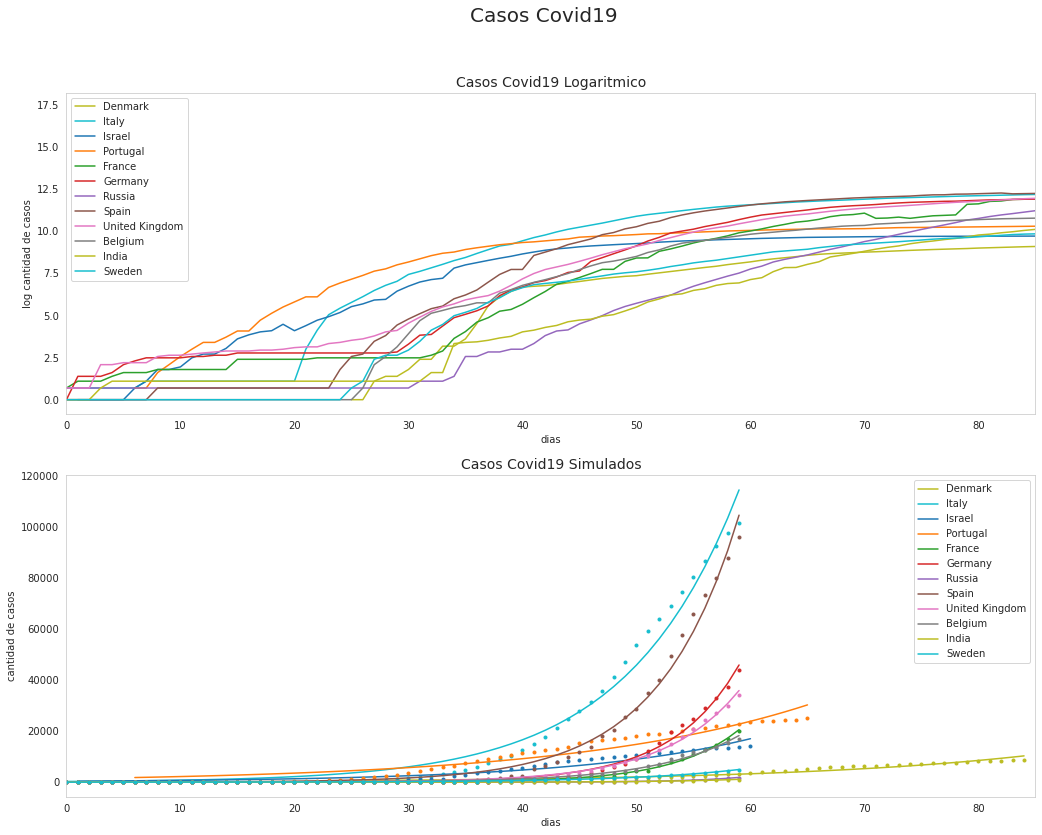

In [279]:
lista_k,lista_casos_max,lista_population = calcular_k(lista_paises)
print("Promedio de casos máximos en el primer periodo {}".format(np.array(lista_casos_max).flatten().mean() ))

In [ ]:
mean_poblacion_simu = int(np.array(lista_population).flatten().mean())
print("Población media de lso paises elegidos {}".format(mean_poblacion_simu) )
#int(np.array(lista_population).flatten().mean())

In [39]:
#poblacion mundial

2. Analiza si es posible estimar la evolución mundial de la pandemia a partir de lo que obtuviste. Para esto, puedes elaborar un intervalo de confianza para  𝑘  a partir de los que obtuviste y así generar un modelo nuevo, basado en la distribución de  𝑘 . Luego compara el modelo con los datos mundiales.

Graficamos la distribución de K para los módelos obenidos anteriormente para cada pais.

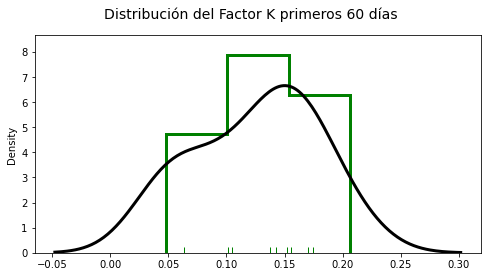

In [40]:
fig, axes = plt.subplots(1, figsize=(8,4))
fig.suptitle('Distribución del Factor K primeros 60 días', fontsize=14)
ax = sns.distplot(lista_k, rug=True, rug_kws={"color": "g"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 1, "color": "g"})

#### Intervalo de confianza basado en percentiles
Mediante bootstrapping, se simula la variabilidad esperada en el estadístico, en este caso la media, debido únicamente al muestreo aleatorio.

In [41]:
def calcular_estadistico(x):
    '''
    Función para calcular el estadístico de interés.
    
    Parameters
    ----------
    x : numpy array
         valores de la muestra.
         
    Returns
    -------
    estadístico: float
        valor del estadístico.
    '''
    estadistico = np.mean(x)
    
    return(estadistico)


def bootstraping(x, fun_estadistico, n_iteraciones=9999):
    '''
    Función para calcular el valor del estadístico en múltiples muestras generadas
    mediante muestreo repetido con reposición (bootstrapping).
    
    Parameters
    ----------
    x : numpy array 
        valores de la muestra.
 
    fun_estadistico : funcion
        función que recibe como argumento una muestra y devuelve el valor
        del estadístico.
        
    n_iteraciones : int
        número iteraciones (default `9999`).
        
    Returns
    -------
    distribuciones: numpy array
        valor del estadístico en cada muestra de bootstrapping.
    '''
    
    n = len(x)
    #Return a new array of given shape and type, filled with fill_value. Array con con shape 9999 y todos los valores en nan
    dist_boot = np.full(shape=n_iteraciones, fill_value=np.nan)
    
    for i in tqdm(range(n_iteraciones)):
        resample = np.random.choice(x, size=n, replace=True)
        dist_boot[i] = fun_estadistico(resample)
        
    return dist_boot

Calcular el estadístico, en este caso la media

In [42]:
# Convertir lista a array
datos = np.array(lista_k)

In [43]:
dist_boot = bootstraping(
                x = datos,
                fun_estadistico = calcular_estadistico,
                n_iteraciones   = 9999
            )

100%|██████████| 9999/9999 [00:00<00:00, 21878.62it/s]


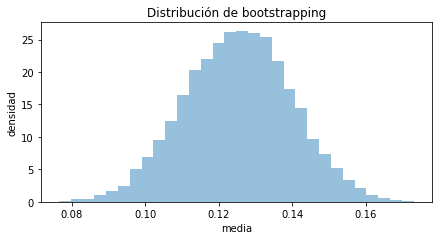

In [44]:
# Distribución de bootstrapping
# ==============================================================================
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,3.3))
ax.hist(dist_boot, bins=30, density=True, color='#3182bd', alpha=0.5)
ax.set_title('Distribución de bootstrapping')
ax.set_xlabel('media')
ax.set_ylabel('densidad');

La dispersión de la distribución obtenida por bootstrapping es una aproximación del error estándar esperado debido a proceso de muestreo. Por esta razón, pueden emplearse sus percentiles para calcular intervalos de confianza. 

Ahora generemos el intervalo de confianza.  Primero hay que elegir $\alpha$, el error que estamos dispuestas/os a cometer. En este caso tomaremos $\alpha=0.05$, que implica que toleraremos hasta un 5% de error.

Una vez establecido alpha, podemos armar el intervalo de confianza para saber con un 95% un intervalo donde se encuentra el promedio $\mu$ de toda la población, usando una submuestra de esta. 

In [45]:
# Intervalo IC basado en percentiles de la distribución bootstrapping
# ==============================================================================
# Un IC del 95% debe abarcar desde el cuantil 0.025 al 0.975
cuantiles = np.quantile(a = dist_boot, q = [0.025, 0.975])
print('-------------------------------')
print('Intervalo de confianza de K basado en percentiles es:')
print('-------------------------------')
print(cuantiles)

-------------------------------
Intervalo de confianza de K basado en percentiles es:
-------------------------------
[0.09697596 0.1534271 ]


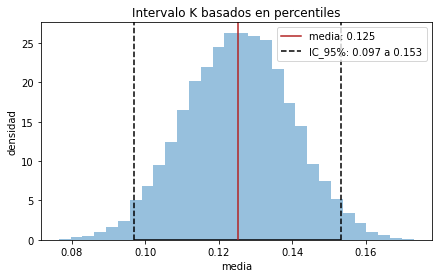

In [46]:
# Gráfico intervalo de confianza del 95% para K, aceptando un error de 5%
# ==============================================================================
media_obs = datos.mean()
media_obs = "{:.3f}".format(datos.mean())
media_obs = "media: " + media_obs

int_obs_izq = list(cuantiles)
int_obs_izq = "{:.3f}".format(cuantiles[0])
int_obs_der = "{:.3f}".format(cuantiles[1])

IC_95 = "IC_95%: " + int_obs_izq +" a "+ int_obs_der

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,4))
ax.hist(dist_boot, bins=30, density=True, color='#3182bd', alpha=0.5)
#ax.axvline(x=datos.mean(), color='firebrick', label='media observada')
ax.axvline(x=datos.mean(), color='firebrick', label=media_obs)

#ax.axvline(x=cuantiles[0], color='black', linestyle='--', label=IC 95%)
ax.axvline(x=cuantiles[0], color='black', linestyle='--', label=IC_95)
ax.axvline(x=cuantiles[1], color='black', linestyle='--')
ax.hlines(y=0.001, xmin=cuantiles[0], xmax=cuantiles[1], color='black')
ax.set_title('Intervalo K basados en percentiles')
ax.set_xlabel('media')
ax.set_ylabel('densidad')
ax.legend();

Redifinimos la función exponencial con los parámetros obtenidos de `K` y `t0`, luego probamos con datos reales de otros países

In [47]:
k=float("{:.3f}".format(datos.mean()))
t0=np.median(lista_t0)
print(k)
print(t0)

0.125
-17.14358317095558


In [48]:
#definimos función para ajustar modelo
def exponencial_new(t,k,t0):
  C=np.exp(k*(t-t0))
  return C

In [49]:
# Definimos la función para predecir la curva de contagios para x pais según el valor de k obtenido.

#def predecir(lista_paises,k,t0):
def predecir2(x_pais,k,t0):
    '''
    Función para calcular el valor de k.
    
    Parameters
    ----------
    lista_paises : lista con los nombres de los 
        paises a evaluar.
         
    Returns
    -------
    valor k: lista
        con valor de k.
    '''    

#    for x_pais in lista_paises:
    #seleccionamos Pais
    print("Pais seleccionado: {}".format(x_pais))
    ind_xpais=np.where(paises==x_pais)
    ind_xpais=ind_xpais[0]
    
    casos_xpais=confirmados[ind_xpais]
    dias=np.arange(0,len(casos_xpais))
    #Imputamos los nan con 0
    #casos_xpais.fillna(0, inplace=True)
    
        #Transformamos a lista
    lst = list(casos_xpais)
    # Buscamos el primer valor no nulo, sería el primer día con casos
    ##from numpy import nan
    #casos_arg[np.isfinite(casos_arg)][0]
    primer_caso=lst[lst.index(next(filter(lambda x: not np.isnan(x), lst)))]
    # Buscamos el indice del primer elemento no nulo
    ind_x = lst.index(next(filter(lambda x: not np.isnan(x), lst)))
    # primer caso de covid en Pais_X
    dia_start = datos2.date.loc[ind_x]
    print("En {} el/los primer/primeros {} casos fue el día {} indice {}".format(x_pais,primer_caso, dia_start, ind_x))
    
    ## Graficamos
    #fig, ax = plt.subplots(figsize=(8,3))
    dias=np.arange(0,len(casos_xpais))
    ############### indices inicio y final
    ind_inicio = ind_x
    #ind_inicio = 0
    ind_final = ind_inicio + 60
    #ind_final = ind_inicio 
        
        ################# Estimamos K

    dias_x=np.arange(ind_x,ind_final)
    #dias_x=np.arange(0,60)

    print("----dias_x para simulacion-----")
    print(list(dias_x))
    #print("{} ind_inicio {}  ind_final {}".format(x_pais,ind_inicio,ind_final))
    casos_principio=casos_xpais[ind_inicio:ind_final]
    dias_principio=dias[ind_inicio:ind_final]
    #print("----dias_principio casos reales------")
    #print(list(dias_principio)) 
    #print("------casos_principio reales-----")
    #print(list(casos_principio.astype(int)))

    #ajustamos, popt[0] es nuestro "K" y popt[1] t0
    #popt, pcov = curve_fit(exponencial, dias_principio, casos_principio)
    #popt
    
    #Guardamos el valor de k en la lista:
    #lista_k.append(popt[0])

    # Ajustamos los datos con los valores de los parámetros obtenidos
    #k=popt[0]
    #t0=popt[1]
    #print("PARAMETRO K: ",k)    
    #print("PARAMETRO t0: ",t0)
    #print(dias_principio.size)
    #print(casos_principio.size)
    #print(dias_x.size)
    casos_simu=exponencial_new(dias_x,k,t0)
    #print(casos_simu.size)
    print("-----casos_simu------")
    print(list(casos_simu.astype(np.int)))
    
    # Prediccion usando el intervalo de confianza k
    casos_simu_izq=exponencial_new(dias_x,float(int_obs_izq),t0)
    casos_simu_der=exponencial_new(dias_x,float(int_obs_der),t0)
    
   
    ## Graficamos las simulaciones
    #label_simu=x_pais + " simulados"
    #label_real=x_pais + " reales"

    #color de la lineas
    color = next(ax._get_lines.prop_cycler)['color']
#    axes.plot(dias_principio,casos_principio,label=label_real, color=color)
    #axes.plot(dias_principio,casos_simu,label=x_pais, color = color)
    #axes.plot(0,dias,'.', color=color)
#    axes.plot(dias_x,casos_simu,'.',label=label_simu, color = color)
    #axes.set_xlabel('das')
    #axes.set_ylabel('cantidad de casos')
#    axes.legend()
#    plt.xlim([ind_inicio,ind_final])
        
    return dias_principio,casos_principio,dias_x,casos_simu,color,casos_simu_izq,casos_simu_der

Pasamos la lista de paises a evaluar

Pais seleccionado: Brazil
En Brazil el/los primer/primeros 1.0 casos fue el día 2020-02-24 indice 0
----dias_x para simulacion-----
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
-----casos_simu------
[8, 9, 10, 12, 14, 15, 18, 20, 23, 26, 29, 33, 38, 43, 49, 55, 62, 71, 80, 91, 103, 117, 133, 151, 171, 194, 219, 249, 282, 319, 362, 410, 465, 527, 597, 677, 767, 869, 985, 1116, 1265, 1433, 1624, 1840, 2085, 2363, 2678, 3034, 3439, 3896, 4415, 5003, 5670, 6424, 7280, 8249, 9348, 10592, 12003, 13601]
Mean Absolute Error: 9994.821100668405
Mean Squared Error: 271415118.2640584
Root Mean Squared Error: 16474.681127841548
Pais seleccionado: Chile
En Chile el/los primer/primeros 2.0 casos fue el día 2020-02-24 indice 0
----dias_x para simulacion-----
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17

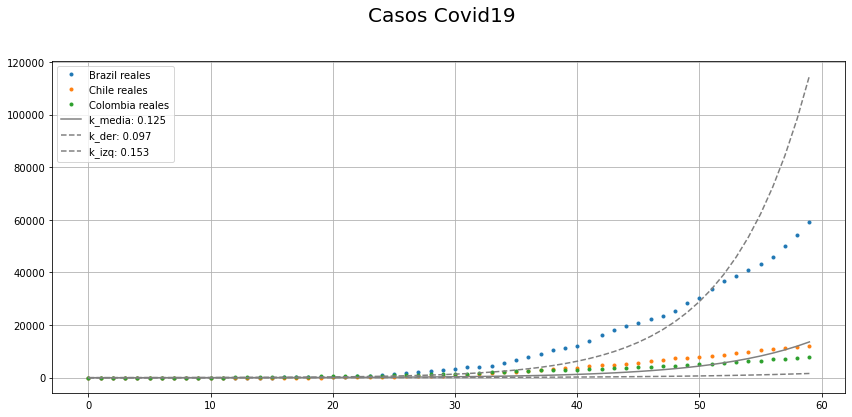

In [50]:
lista_paises = ['Argentina','Brazil','Chile','Colombia']
lista_paises = ['Brazil','Chile','Colombia']
#lista_paises = ['Argentina']

#armamos la figura para el gráfico
#fig, ax = plt.subplots(figsize=(15,6))
fig, axes = plt.subplots(1, figsize=(12, 6))
fig.suptitle('Casos Covid19', fontsize=20)
fig.tight_layout(pad=2.0)


#axes.set_title('Casos Covid19 Simulados {}'.format(x_pais),fontsize=14, loc='center')
#axes.set_xlim([0, 120])
axes.grid()

#color lineas gráfico
marker = itertools.cycle(('o', 'v', '^', '<', '>', 's', '8', 'p'))

for x_pais in lista_paises:
    #dias_principio,casos_principio,dias_x,casos_simu,casos_simu_izq,casos_simu_der,color = predecir2(x_pais,k,t0)
    dias_principio,casos_principio,dias_x,casos_simu,color,casos_simu_izq,casos_simu_der = predecir2(x_pais,k,t0)
 
    label_simu = "{} simulados".format(x_pais)
    label_real = "{} reales".format(x_pais)  
    
    #print(color)
    axes.plot(dias_principio,casos_principio,'.',label=label_real, color=color)
    #plt.xlim([ind_inicio,ind_final])
    #print(lista)
    #print("----dias_principio casos reales------")
    #print(list(dias_principio)) 
    #print("------casos_principio reales-----")
    #print(list(casos_principio.astype(int)))
    
    #### Calculamos el error
    print('Mean Absolute Error:', metrics.mean_absolute_error(casos_principio, casos_simu))  
    print('Mean Squared Error:', metrics.mean_squared_error(casos_principio, casos_simu))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(casos_principio, casos_simu)))
    
#label_k_media = "k_media: ",float("{:.3f}".format(datos.mean()))
#label_k_izq = "k_der: ", float(int_obs_izq)
#label_k_der = "k_izq: ", float(int_obs_der)

label_k_media = "k_media: {}".format(round(datos.mean(),3))
label_k_izq = "k_der: {}".format(float(int_obs_izq))
label_k_der = "k_izq: {}".format(float(int_obs_der))


axes.plot(dias_x,casos_simu,label=label_k_media, color = 'grey')
axes.plot(dias_x,casos_simu_izq,label=label_k_izq, linestyle='--', color = 'grey')
axes.plot(dias_x,casos_simu_der,label=label_k_der, linestyle='--', color = 'grey')

#sns.regplot(dias_x,casos_simu,label="modelo", color = 'grey',ci=50)

#axes.plot(dias_x,casos_simu,'.',label=label_simu, color = 'red')
axes.legend()

##### 

Aquí se observa como se despega la curva de contagíos predicha con la real utilizando el modelo entrenado con datos de los paises donde comenzó la epidemia. 

Con los paises elegidos para entrenar nuestro modelo (obtener los parámetros k y t0) el primer caso de Covid fue detectado el 22 de Febrero.

- Argentina: se detectó el primer caso el 2020-04-26, es decir 62 días después de detectado el primer caso en el mundo. La cuarentena comenzó el 20 de marzo tomando medidas muy estrictas.

- Brasil: no se tomaron medidas de resticciones, con lo cual el modelo aproxima a la curva simulada.

- Chile: la cuarentena comenzó el 26 de Marzo, el primer caso fue el 2020-02-24, con lo cual al principio la curva simulada se asemeja al de los casos reales en los paises del emisferio Norte seleccionados, luego se produce una separación por las medidas de cuarentena tomadas.

- Colombia: la cuarentena comenzó el 25 de Marzo, el primer caso fue el 2020-02-24

Creamos una dataframe con los datos reales y los predicho por el modelo para un momento x.

In [51]:
#flatten() function return a copy of the array collapsed into one dimension
df = pd.DataFrame({'Actual': np.array(casos_principio).flatten(), 'Predicted': casos_simu.flatten()})
df.head()

,Actual,Predicted
0,1.0,8.524530
1,1.0,9.659558
2,1.0,10.945713
3,1.0,12.403118
4,3.0,14.054574


Comparamos el modelo obtenido con la evolución de casos de covid-19 a nivel mundial:

In [52]:
df = datos_orig

In [53]:
#Filtramos los casos mundiales
df = df[df['location'] == 'World']

In [54]:
#poblacion mundial
poblacion_mundial = int(df.population[125123])
poblacion_mundial

7874965730

In [55]:
# promedio de la poblacion para el fiteo
mean_poblacion_simu

39835428

In [56]:
## relacion entre poblacion total y la del modelo
factor_correccion = poblacion_mundial / mean_poblacion_simu
factor_correccion

197.6874888855217

In [57]:
fechas = []
contagios_mundiales = []

for i in tqdm(df.date.unique()):
  contagios = df.loc[df['date'] == i,['total_cases']].sum()
  contagios_mundiales.append(int(contagios))
  fechas.append(i)

100%|██████████| 649/649 [00:01<00:00, 576.58it/s]


In [58]:
#contagios_mundiales = pd.DataFrame(contagios_mundiales, columns=['total_cases'])
#contagios_mundiales.iloc[3]

In [59]:
# Creamos el dataframe con los datos anteriormente generados
d = {'date': fechas, 'total_cases': contagios_mundiales}
df_casos_mundo = pd.DataFrame(d)
df_casos_mundo.date = pd.to_datetime(df_casos_mundo.date)
df_casos_mundo.set_index(df_casos_mundo.date, inplace = True)
df_casos_mundo.drop(columns = ["date"], inplace = True)
df_casos_mundo.sort_index(inplace = True)

In [60]:
# Dia en que se detecto el primer caso en el mundo, 2020-01-22     557 casos
df_casos_mundo['total_cases'][0:5]

date
2020-01-22     557
2020-01-23     655
2020-01-24     941
2020-01-25    1434
2020-01-26    2118
Name: total_cases, dtype: int64

In [61]:
# Reseteamos el indice, cambiamos el indice date por un indice númerico consecutivo incremental
df_casos_mundo_dias = df_casos_mundo.reset_index(drop = True, inplace=False)
#df_casos_mundo_dias[0:3]

Definimos periodo de observación, como el modelo fue creado con una función exponencial con datos al principio de la pandemia, vamos a analizar mismo perioro para contrastar lo simulado (predicho), con los casos reales.

In [62]:
#definimos periodo analizar
ind_start = 0
ind_stop = 60
#ind_start = 0
#ind_stop = 700

# predecimos
dias_x=np.arange(ind_start,ind_stop)
casos_simu=exponencial(dias_x,k,t0)

#filtramos los casos reales para ese periodo
df_casos_mundo_dias_x =  df_casos_mundo_dias[ind_start:ind_stop]
#df_casos_mundo_dias_x


In [63]:
#casos_simu

Gráficamos los casos reales a nivel mundial (acumulados) y en un segundo gráfico comparamos lo predicho con lo real.

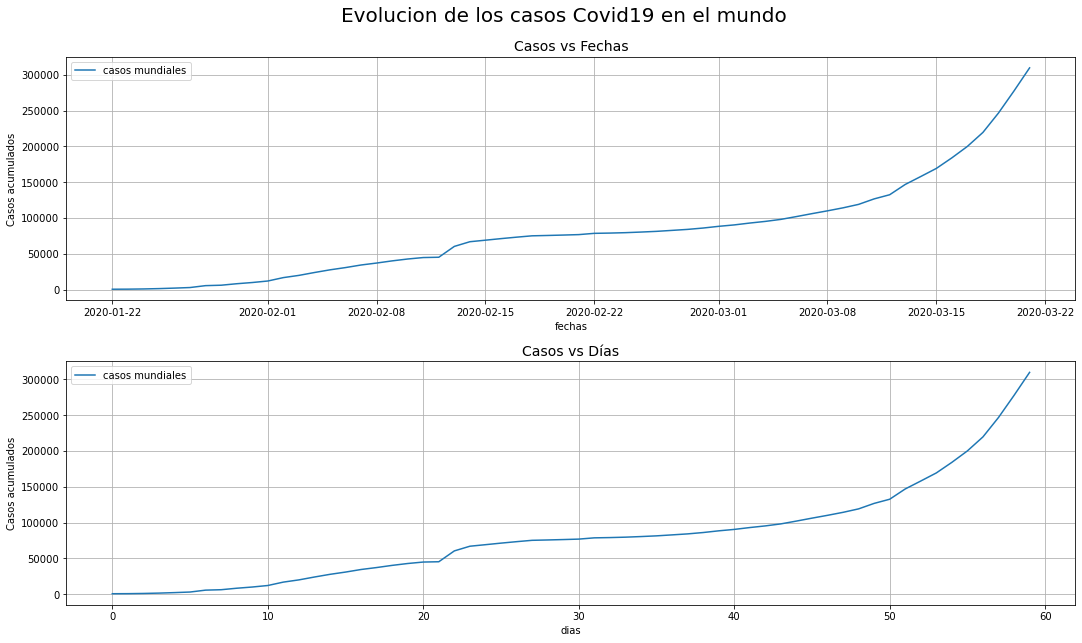

In [64]:
#armamos la figura para el gráfico
    #fig, ax = plt.subplots(figsize=(15,6))
fig, axes = plt.subplots(2, figsize=(15, 9))
fig.suptitle('Evolucion de los casos Covid19 en el mundo', fontsize=20)
#fig.tight_layout(pad=4.0)
fig.tight_layout(pad=2, w_pad=0.5, h_pad=4.0)

#titulos
axes[0].set_title('Casos vs Fechas',fontsize=14, loc='center')
#axes[0].set_xlim([0, 85])
axes[0].grid()

axes[1].set_title('Casos vs Días',fontsize=14, loc='center')
#axes[1].set_xlim([0, 85])
#axes[1].set_ylim([0, 500000])
axes[1].grid()


## Graficamos Casos vs Fechas
#ax.set_xticklabels(models, rotation=0)    
axes[0].plot(df_casos_mundo['total_cases'][ind_start:ind_stop],label="casos mundiales")
axes[0].set_xlabel('fechas')
axes[0].set_ylabel('Casos acumulados')
#ax.set_xticklabels(models, rotation=0)
axes[0].legend()

## Graficamos Casos vs Dias
#ax.set_xticklabels(models, rotation=0)    
#axes[1].plot(df_casos_mundo_dias['total_cases'],label="casos mundiales")
axes[1].plot(df_casos_mundo_dias_x,label="casos mundiales")
axes[1].set_xlabel('dias')
axes[1].set_ylabel('Casos acumulados')
##ax.set_xticklabels(models, rotation=0)
#axes[1].plot(casos_simu,label="casos simulados")
#axes[1].plot(casos_simu_izq,label="casos simulados izq",color = 'grey')
#axes[1].plot(casos_simu_der,label="casos simulados der",color = 'grey')

axes[1].legend()

plt.show()

#### 3) Piensa qué significa que el modelo de "bien" o dé "mal" ¿qué indicadores de esto existen?. Luego discute en el informe por qué crees que dio así. Recuerda que es importante elegir bien la población de muestra. Piensa qué criterios puedes elegir para representar bien la población mundial que se contagió al inicio de la pandemia.



In [65]:
#flatten() function return a copy of the array collapsed into one dimension
#df = pd.DataFrame({'Actual': np.array(df_casos_mundo_dias_x).flatten(), 'Predicted': casos_simu.flatten()})
df = pd.DataFrame({'Actual': np.array(np.log(df_casos_mundo_dias_x)).flatten(), 'Predicted': np.log(casos_simu*factor_correccion).flatten()})

df.head(5)

,Actual,Predicted
0,6.322565,7.429635
1,6.484635,7.554635
2,6.846943,7.679635
3,7.268223,7.804635
4,7.658228,7.929635


In [66]:
#df_casos_mundo_dias_x

In [67]:
#### Calculamos el error pero con los datos aplicando logaritmo para escalarlos
print('Mean Absolute Error:', int(metrics.mean_absolute_error(np.log(df_casos_mundo_dias_x), np.log(casos_simu*factor_correccion))  ) )  
print('Mean Squared Error:', int(metrics.mean_squared_error(np.log(df_casos_mundo_dias_x), np.log(casos_simu*factor_correccion)) ) )  
print('Root Mean Squared Error:', int(np.sqrt(metrics.mean_squared_error(np.log(df_casos_mundo_dias_x), np.log(casos_simu*factor_correccion)) )))

Mean Absolute Error: 1
Mean Squared Error: 1
Root Mean Squared Error: 1


Los casos al principio que se utilizaron en el modelo para fittear fue en promedio de 1, los casos reales parte de 557 casos. Con lo cual podemos escalar los datos con una realación de 1:557

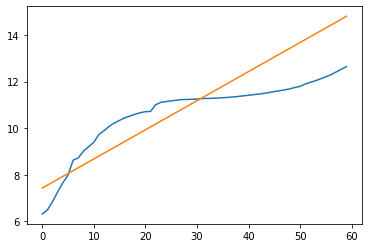

In [68]:
plt.plot(np.log(df_casos_mundo_dias_x))
plt.plot(np.log(casos_simu*factor_correccion))

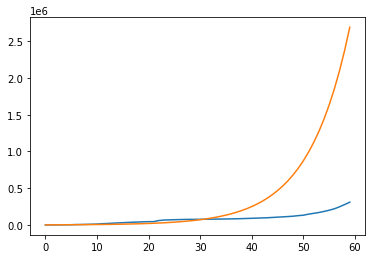

In [69]:
plt.plot(df_casos_mundo_dias_x)
plt.plot(casos_simu*factor_correccion)

In [70]:
#plt.plot(casos_simu)

In [71]:
#### Calculamos el error pero con los datos aplicando logaritmo para escalarlos
print('Mean Absolute Error:', int(metrics.mean_absolute_error(df_casos_mundo_dias_x, casos_simu*factor_correccion))  ) 
print('Mean Squared Error:', int(metrics.mean_squared_error(df_casos_mundo_dias_x, casos_simu*factor_correccion) ) )  
print('Root Mean Squared Error:', int(np.sqrt(metrics.mean_squared_error(df_casos_mundo_dias_x,casos_simu*factor_correccion)) ))

Mean Absolute Error: 315114
Mean Squared Error: 412408918178
Root Mean Squared Error: 642190


Una Mejor aproximación, sería entrenar el modelo con los datos de casos por millon de habitantes `total_cases_per_million`, así ahí trabajar con un modelo de proporciones.

### Evaluando estrategias

 Ahora que tienes una manera de obtener información de las curvas, puedes intentar evaluar las estrategias de acción y el comportamiento de las poblaciones, construyendo un clasificador binario. 
1. Elige una categoría binaria que hable de políticas públicas elegidas por los países para enfrentar la pandemia que te interese estudiar, como pueden ser "la población hizo cuarententa" o "la población se vacunó".
2. Piensa qué indicadores de la curva pueden hablar del éxito de la política que quieres estudiar. Por ejemplo, si se tratase de evaluar el éxito de una cuarentena podría ser porcentaje de población  que se contagió o variación del valor de $k$ a partir de que se empezó a implementar esa medida. Elige al menos 3 indicadores.
3. Investiga sobre países que hayan aplicado o no esa política pública, para generar una base de datos. Por ejemplo, Brasil no hizo cuarentena y China hizo una muy estricta. Recuerda hacer una selección inteligente de la porción de datos de la curva de cada país que vas a analizar.
4. Construye un clasificador binario a partir de una regresión logística o usando Naive Bayes para intentar analizar la estrategia de otros países y ver si es posible predecirla a partir de la curva de contagios y el clasificador. Un posible clasificador binario es uno que clasifique el porcentaje de contagios en función da las categorías "la población hizo cuarentena" y "la población n hizo cuarentena". Haz esto para los 3 indicadores que elegiste en el punto 3 y compara los resultados.
5. Elabora un informe con lo que hayas aprendido a lo largo de este proyecto, donde discutas la utilidad o no de los indicadores que elegiste y del análisis estadístico propuesto.

### Comenzamos

https://github.com/owid/covid-19-data/tree/master/public/data


1 - Vamos a clasificar las poblaciones que realizaron cuarentena y las que no. La metrica Policy responses tenemos datos de 186/233 paises, con lo cual comenzaremos a filtrar cuales son esos paises.


Variable es `stringency_index` Government Response Stringency Index: composite measure based on 9 response indicators including school closures, workplace closures, and travel bans, rescaled to a value from 0 to 100 (100 = strictest response)

In [191]:
df = datos_orig.copy()

In [192]:
df.location.unique().size

233

Top de paises que más días realizaron cuarentena (cada día tiene un indicador de la cuarentena aplicada, siendo 0 el nivel más bajo de restricción y 100 la más estricta según una escala establecida por 9 preguntas).

In [193]:
#df_cuarentena = df.groupby('location')['stringency_index'].agg('count').sort_values(ascending=False) 
#df_cuarentena
#df_cuarentena_sum = df.groupby('location')['stringency_index'].agg(np.sum)
#df_cuarentena_sum

In [194]:
#df1 = df.groupby(by='location').agg({'stringency_index': ['sum','count']}).reset_index().rename(columns={'sum':'Suma'} )

In [195]:
df_cuarentena = df.groupby(by='location')['stringency_index'].agg(['count','sum','median','mean']).sort_values(by='count',ascending=False)
#df_cuarentena['median']

In [196]:
#paises que no hicieron cuarentena
#df_sin_cuerentena = df_cuarentena.to_frame()
df_sin_cuerentena = df_cuarentena[df_cuarentena['count'].sort_values(ascending=True) == 0]
df_sin_cuerentena

df_sin_cuerentena = pd.DataFrame(df_sin_cuerentena)
df_sin_cuerentena['pais'] = df_sin_cuerentena.index
#df_sin_cuerentena.drop(['B', 'C'], axis=1)
df_sin_cuerentena = df_sin_cuerentena['pais']
#df_sin_cuerentena.rename({'app_name': 'cnt'}, axis=1, inplace=True)
df_sin_cuerentena.reset_index(drop=True, inplace=True)
df_sin_cuerentena = pd.DataFrame(df_sin_cuerentena)
df_sin_cuerentena = df_sin_cuerentena[['pais']].sort_values(['pais'], ascending=True)
print("a primera vista hay {} paises que no realizaron cuarentena".format(df_sin_cuerentena.size))
df_sin_cuerentena.head(10)

a primera vista hay 51 paises que no realizaron cuarentena


,pais
26,Africa
4,Anguilla
22,Antigua and Barbuda
49,Armenia
21,Asia
24,Bonaire Sint Eustatius and Saba
23,British Virgin Islands
28,Cayman Islands
42,Comoros
45,Cook Islands


Filtramos los continentes y demás que no corresponden con paises.

In [197]:
list_quitar = ['World','South America','Oceania','European Union','Europe','Asia','Africa']

In [198]:
df_sin_cuerentena = df_sin_cuerentena[~df_sin_cuerentena.isin(list_quitar)]

In [199]:
#Dropeamos los nulos y reseteamos el indice
df_sin_cuerentena.dropna(inplace=True)
df_sin_cuerentena.reset_index(drop=True, inplace=True)
print("Quitando los datos que no corresponden hay {} paises que no realizaron cuarentena".format(df_sin_cuerentena.size))
df_sin_cuerentena.head()

Quitando los datos que no corresponden hay 44 paises que no realizaron cuarentena


,pais
0,Anguilla
1,Antigua and Barbuda
2,Armenia
3,Bonaire Sint Eustatius and Saba
4,British Virgin Islands


Definir el top de paises a filtrar

In [200]:
# Definir el top de paises a filtrar
top_n = 20

In [201]:
df_cuarentena = pd.DataFrame({'pais': df_cuarentena.index,
                                        'dias_cuarentena': df_cuarentena['count'].values,
                                        'acum_restriccion': df_cuarentena['sum'].values,
                                        'mean_restriccion': df_cuarentena['mean'].values,
                                        'median_restriccion': df_cuarentena['median'].values
                                 })

# ordenamos los paises con la cuarentena más larga
#df_cuarentena = df_cuarentena.sort_values(by='dias_cuarentena',ascending=False)[0:top_n]
df_cuarentena[0:top_n]

,pais,dias_cuarentena,acum_restriccion,mean_restriccion,median_restriccion
0,Argentina,664,48218.06,72.617560,79.170
1,Peru,656,46099.07,70.272973,75.930
2,Thailand,654,33124.13,50.648517,52.780
3,Mexico,651,35881.29,55.117189,67.130
4,United States,648,38235.11,59.004799,63.425
5,South Korea,644,34072.42,52.907484,53.240
6,Hong Kong,642,40154.84,62.546480,65.740
7,Taiwan,642,21663.93,33.744439,25.000
8,Finland,641,27894.43,43.517051,43.980
9,Japan,641,26463.28,41.284368,45.370


Calculamos los estadísticos

In [202]:
df_cuarentena.describe()

,dias_cuarentena,acum_restriccion,mean_restriccion,median_restriccion
count,233.000000,233.000000,182.000000,182.000000
mean,454.442060,25720.790644,56.004154,55.456538
std,252.199971,15943.725555,12.893943,14.999112
min,0.000000,0.000000,11.026462,8.330000
25%,290.000000,9711.510000,48.594756,45.602500
50%,587.000000,31504.620000,57.275461,56.480000
75%,606.000000,38061.170000,65.024706,67.130000
max,664.000000,50203.710000,85.091034,86.110000


Graficamos la distribución de los días de cuarentena y su severidad.

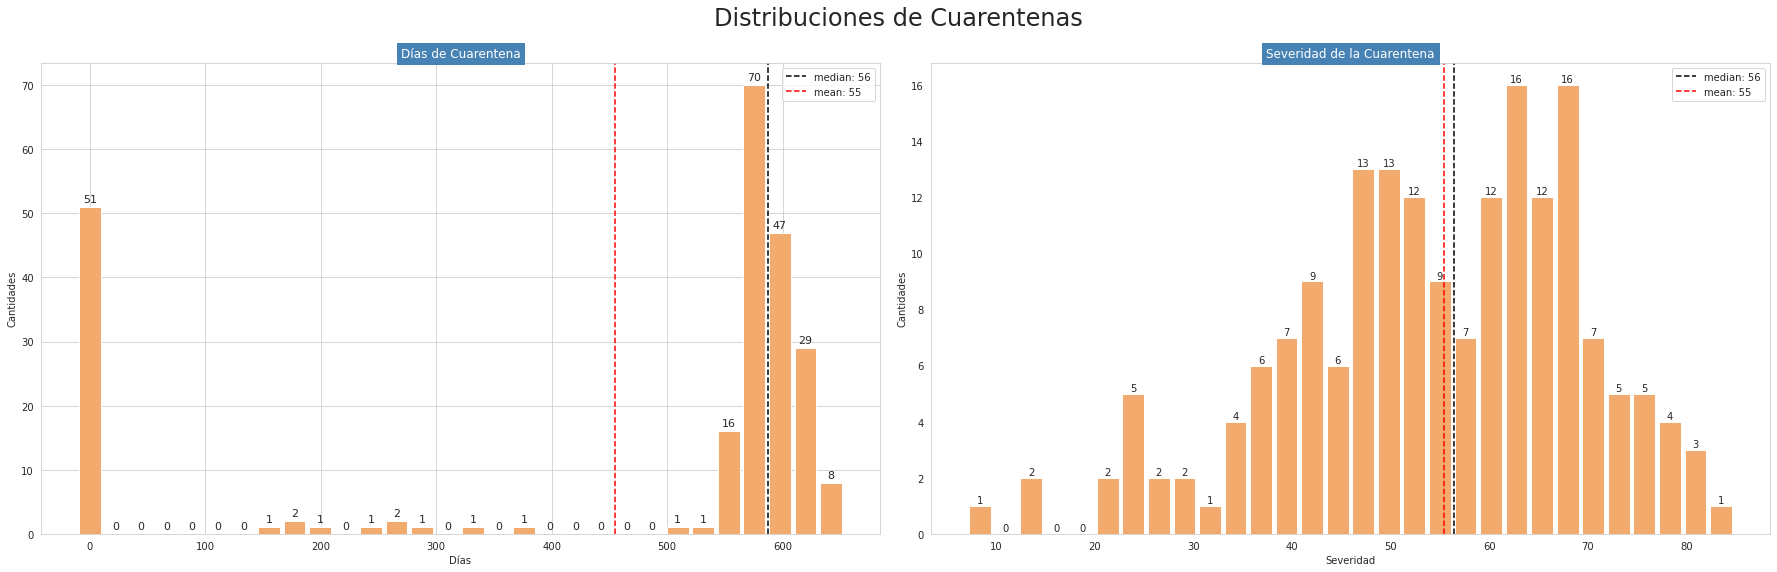

In [211]:
#intervalos = range(int(min(df_cuarentena['acum_restriccion'])), int(max(df_cuarentena['acum_restriccion'])) + 2) #calculamos los extremos de los intervalos
intervalo1 = 30
intervalo2 = 30

## creamos la figura con subplots de 1 linea 2 columnas
fig, axes = plt.subplots(1,2, figsize=(25, 8))
fig.suptitle('Distribuciones de Cuarentenas', fontsize=24)
#padding between subplots. Pass a float parameter to specify the amount of padding between subplots.
fig.tight_layout(pad=2.0)
plt.grid()

# Grafico 0
label_median = "median: {}".format( int(df_cuarentena['median_restriccion'].median()) )
label_mean = "mean: {}".format( int(df_cuarentena['median_restriccion'].mean()) )

#sns.countplot(data = df, x = "price", orient='v', order = df['price'].value_counts().index)
axes[0].set_title("Días de Cuarentena",fontsize = 12, color = "w", fontstretch=0, backgroundcolor="SteelBlue")
axes[0].hist(x=df_cuarentena['dias_cuarentena'], bins=intervalo1, color='#F2AB6D', rwidth=0.85, align='left')
#axes.set_title("Todas los tipos: ",fontsize = 10, color = "w", fontstretch=0, backgroundcolor="SteelBlue")
#plt.sca(axes[0, 1])
#plt.sca(axes[0])
plt.xticks(rotation=45)
axes[0].set_xlabel("Días")
axes[0].set_ylabel("Cantidades")
#axes[0].set_xlim([47,215]) ## limite en x, para acotar y quitar los outliers
axes[0].axvline(x=df_cuarentena['dias_cuarentena'].median(), color='black', linestyle='--', label=label_median)
axes[0].axvline(x=df_cuarentena['dias_cuarentena'].mean(), color='red', linestyle='--', label=label_mean)
axes[0].legend()

count=0
for rect in axes[0].patches:
    count +=1
    if count <= intervalo1:  
        # prints the quit message
        #print(quit)
        axes[0].text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,int(rect.get_height()),horizontalalignment='center', fontsize = 11)

#Grafico 1
label_median = "median: {}".format( int(df_cuarentena['median_restriccion'].median()) )
label_mean = "mean: {}".format( int(df_cuarentena['median_restriccion'].mean()) )

axes[1].set_title("Severidad de la Cuarentena",fontsize = 12, color = "w", fontstretch=0, backgroundcolor="SteelBlue")
axes[1].hist(x=df_cuarentena['median_restriccion'], bins=intervalo2, color='#F2AB6D', rwidth=0.85, align='left')

#plt.sca(axes[0, 1])
#plt.sca(axes[0])
plt.xticks(rotation=0)
axes[1].set_xlabel("Severidad")
axes[1].set_ylabel("Cantidades")
#axes[1].set_xlim([0,10]) ## limite en x, para acotar y quitar los outliers
axes[1].axvline(x=df_cuarentena['median_restriccion'].median(), color='black', linestyle='--', label=label_median)
axes[1].axvline(x=df_cuarentena['median_restriccion'].mean(), color='red', linestyle='--', label=label_mean)

axes[1].legend()

count=0
for rect in axes[1].patches:
    count +=1
    if count <= intervalo2:  
        #axes[1].text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 10)
        axes[1].text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.1,int(rect.get_height()),horizontalalignment='center', fontsize = 10)
plt.show()


In [212]:
#print(list(df_cuarentena['pais']))
#df_cuarentena[0:top_n]

In [213]:
#list_top_pais = ['Argentina', 'Peru', 'Thailand', 'Mexico', 'United States', 'South Korea', 'Hong Kong', 'Taiwan', 'Finland', 'Japan', 'Vietnam', 'Singapore', 'Nepal', 'Italy', 'France', 'United Kingdom', 'Denmark', 'Cambodia', 'China', 'Canada']
list_top_pais = list(df_cuarentena['pais'][0:top_n])
len(list_top_pais)

20

In [214]:
df_top = df.loc[df['location'].isin(list_top_pais)]
len(df_top.location.unique())

20

In [215]:
# ordenamos los paises con la cuarentena más larga
df_order = df_cuarentena.sort_values(by='dias_cuarentena',ascending=False)[0:top_n].reset_index()
#df_order['pais']

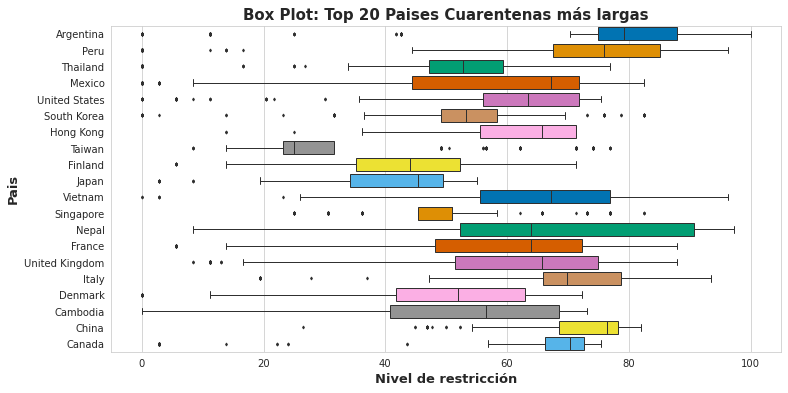

In [219]:
# Creación de box-plot.
n_paises = 20
fig_h = 1 + 0.25 * max(1, n_paises)
fig, ax = plt.subplots(figsize=(12, fig_h))
sns.set_style("whitegrid")
ax = sns.boxplot(x='stringency_index', y='location', data=df_top,
                 order=df_order['pais'].to_list(),
                 palette="colorblind",
                 saturation=1,
                 linewidth=1,
                 fliersize=2)
plt.title('Box Plot: Top {} Paises Cuarentenas más largas'.format(top_n),fontsize=15, fontweight='heavy')
plt.xlabel('Nivel de restricción', fontsize=13, fontweight='demi')
plt.ylabel('Pais', fontsize=13, fontweight='demi')
plt.show()

Se observa como fue la distribución del nivel de restricción durante toda la pandemia. A continuación los que aplicaron medidas más estricas en promedio

In [221]:
#df_cuarentena.sort_values(by='mean_restriccion',ascending=False)[0:top_n].reset_index()

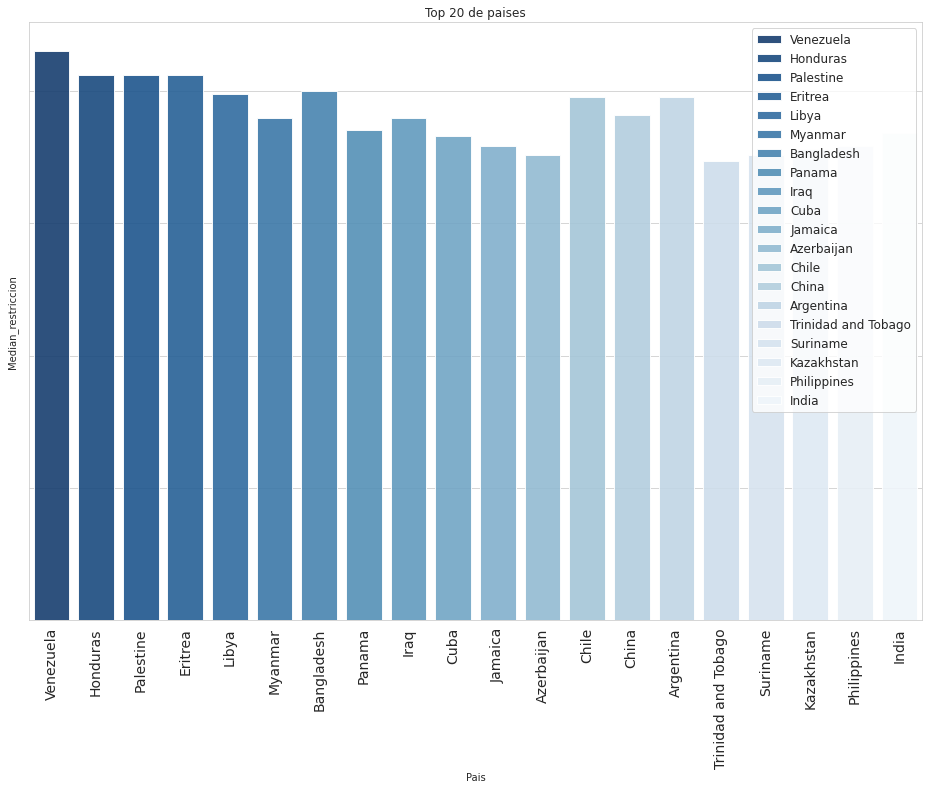

In [224]:
top = df_cuarentena.sort_values(by='mean_restriccion',ascending=False)[0:top_n].reset_index()
#top20['hours']=top20['hours'].round(1)
fig_h = 1 + 0.25 * max(1, 2*20)
fig, axes = plt.subplots(figsize=(16, fig_h))

#plt.figure(figsize=(20, 8))
#axes = sns.set(font_scale = 2)
axes = sns.barplot(x='pais', y='median_restriccion', hue='pais',alpha=0.9,data=top, palette='Blues_r',dodge=False)
axes.set(xlabel='Pais', ylabel='Median_restriccion', title='Top {} de paises'.format(top_n))
#axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
#axes.set_title('Top 20 de paises')
axes.set_xticklabels(axes.get_xticklabels(), rotation=90, fontsize=10)
axes.set_yticklabels(axes.get_yticklabels(), rotation=0, fontsize=10)
axes.xaxis.set_tick_params(labelsize=14)
axes.legend(fontsize=12)
plt.show()

2- Exito de la cuarentena, observar % de población que se contagió, variación de k, cantidad de muertes. internaciones

new_deaths

icu_patients

reproduction_rate


In [454]:
datos_orig.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

In [456]:
datos_orig.icu_patients.head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: icu_patients, dtype: float64

In [457]:
datos_orig.stringency_index

0         8.33
1         8.33
2         8.33
3         8.33
4         8.33
          ... 
127521     NaN
127522     NaN
127523     NaN
127524     NaN
127525     NaN
Name: stringency_index, Length: 127526, dtype: float64

In [283]:
muertes_nuevas = datos_orig['new_deaths'] #carga vector todos las muertes confirmadas
muertes_nuevas = datos_orig['total_deaths'] #carga vector todos las muertes confirmadas
uci_nuevas = datos_orig['icu_patients']
reproduction_rate = datos_orig['reproduction_rate']

(0.0, 200.0)

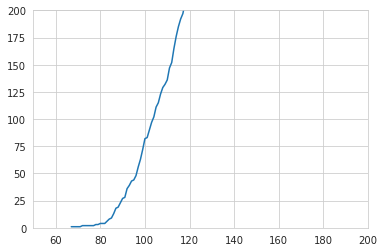

In [261]:
ind_xpais=np.where(paises=='Argentina')
ind_xpais=ind_xpais[0]
ind_xpais
muertes_xpais=muertes_nuevas[ind_xpais]
muertes_xpais.sum()
lst_muertes = list(muertes_xpais)
primer_muerte=lst_muertes[lst_muertes.index(next(filter(lambda x: not np.isnan(x), lst_muertes)))]
# Buscamos el indice del primer elemento no nulo
ind_x_muertes = lst_muertes.index(next(filter(lambda x: not np.isnan(x), lst_muertes)))
dias_muerte=np.arange(0,len(muertes_xpais))
label_muertes = "muertes {}".format(x_pais)
fig = plt.plot(dias_muerte,muertes_xpais,label=label_muertes)
plt.xlim([50,200])
plt.ylim([0,200])

670

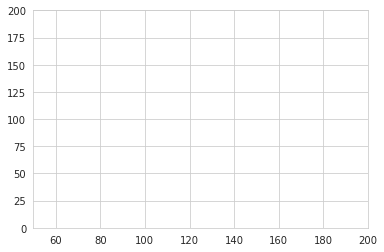

In [307]:
ind_xpais=np.where(paises=='Argentina')
ind_xpais=ind_xpais[0]
ind_xpais
uci_xpais=uci_nuevas[ind_xpais]
uci_xpais.sum()
lst_muertes = list(uci_xpais)
#primer_muerte=lst_muertes[lst_muertes.index(next(filter(lambda x: not np.isnan(x), lst_muertes)))]
## Buscamos el indice del primer elemento no nulo
#ind_x_muertes = lst_muertes.index(next(filter(lambda x: not np.isnan(x), lst_muertes)))
dias_muerte=np.arange(0,len(uci_xpais))
label_muertes = "muertes {}".format(x_pais)
fig = plt.plot(dias_muerte,uci_xpais,label=label_muertes)
plt.xlim([50,200])
plt.ylim([0,200])

uci_nuevas[ind_xpais].isna().sum()

100%|██████████| 1/1 [00:00<00:00, 63.44it/s]


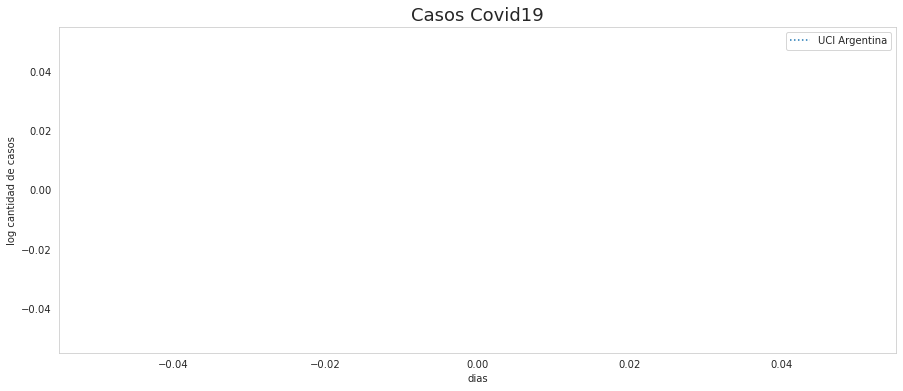

In [300]:
## Inicio de analisis

#lista_paises = ['Argentina','Brazil','Chile','Colombia','France','Germany','Russia','Spain','United Kingdom','United States','India','China']
lista_paises = ['Argentina','Brazil','Chile','Colombia']
#lista_paises = ['Argentina','Brazil']
lista_paises = ['Argentina']

#armamos la figura para el gráfico
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Casos Covid19',fontsize=18, loc='center')
#ax.set_xlim([0, 100])
ax.grid()

for x_pais in tqdm(lista_paises):
    #seleccionamos Argentina
    ind_xpais=np.where(paises==x_pais)
    ind_xpais=ind_xpais[0]
    
    casos_xpais=confirmados[ind_xpais]
    #Transformamos a lista
    lst = list(casos_xpais)
    # Buscamos el primer valor no nulo, sería el primer día con casos
    ##from numpy import nan
    #casos_arg[np.isfinite(casos_arg)][0]
    primer_caso=lst[lst.index(next(filter(lambda x: not np.isnan(x), lst)))]
    # Buscamos el indice del primer elemento no nulo
    ind_x = lst.index(next(filter(lambda x: not np.isnan(x), lst)))
    # primer caso de covid en Argentina
    dia_start = datos2.date.loc[ind_x]
    #print("En {} el/los primer/primeros {} casos fue el día {} indice {}".format(x_pais,primer_caso, dia_start, ind_x))
    
    ###muertes
    muertes_xpais=muertes_nuevas[ind_xpais]
    lst_muertes = list(muertes_xpais)
    primer_muerte=lst_muertes[lst_muertes.index(next(filter(lambda x: not np.isnan(x), lst_muertes)))]
    # Buscamos el indice del primer elemento no nulo
    ind_x_muertes = lst_muertes.index(next(filter(lambda x: not np.isnan(x), lst_muertes)))
    dias_muerte=np.arange(0,len(muertes_xpais))
    
    ## Internaciones UCI
    uci_xpais=uci_nuevas[ind_xpais]
    lst_uci = list(uci_xpais)
    #primer_muerte=lst_uci[lst_uci.index(next(filter(lambda x: not np.isnan(x), lst_uci)))]
    ## Buscamos el indice del primer elemento no nulo
    #ind_x_uci = lst_uci.index(next(filter(lambda x: not np.isnan(x), lst_uci)))
    dias_uci=np.arange(0,len(uci_xpais))
        
    #Graficamos
    #color de la lineas
    color = next(ax._get_lines.prop_cycler)['color']
    
    # Grafico muertes
    label_muertes = "Muertes {}".format(x_pais)
    fig = plt.plot(dias_muerte,np.log(muertes_xpais), linestyle='--',color=color,label=label_muertes)
    
    # Grafico uci
    label_uci = "UCI {}".format(x_pais)
    fig = plt.plot(dias_uci,np.log(uci_xpais), linestyle='dotted',color=color,label=label_uci)  
    
    ## Graficamos
    #fig, ax = plt.subplots(figsize=(8,3))
    label_casos="Casos {}".format(x_pais)
    dias=np.arange(0,len(casos_xpais))
    #ax.set_xticklabels(models, rotation=0)    
    fig = plt.plot(dias,np.log(casos_xpais),color=color,label=label_casos)
    plt.xlabel('dias')
    plt.ylabel('log cantidad de casos')
    #ax.set_xticklabels(models, rotation=0)
    ax.legend()

In [263]:
datos_orig['new_deaths']

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
         ... 
127521    1.0
127522    0.0
127523    0.0
127524    0.0
127525    3.0
Name: new_deaths, Length: 127526, dtype: float64

In [232]:
muertes_nuevas=datos_orig['new_deaths'] #carga vector todos las muertes confirmadas
#casos_arg=confirmados[ind_arg]